In [1]:
from data_prep import *
from PositionModel import *
from PlayerModel import *
from commons import *
import shap
from sklearn.ensemble import RandomForestRegressor

In [2]:
features = ['goals_scored_avg5', 'xG_avg5', 'assists_fpl_avg5',
       'bonus_avg5', 'bps_avg5', 'clean_sheets_avg5', 'goals_conceded_avg5',
       'shots_avg5', 'xGBuildup_avg5', 'xGChain_avg5', 'yellow_cards_avg5',
       'red_cards_avg5', 'was_home', 'rating_diff']
rolling_columns = ['goals_scored', 'xG', 'assists_fpl', 'bonus', 'bps', 'clean_sheets', 'goals_conceded', 'shots', 'xGBuildup', 'xGChain', 'yellow_cards', 'red_cards']
to_predict = 'total_points'

In [3]:
# loading dataset
# previous_games = merged_understat_and_fpl(rolling_columns, True)
previous_games = load_dataset()

In [4]:
# splitting data
X_train = previous_games[features]
y_train = previous_games[to_predict]

In [5]:
for f in X_train.iloc[0]:
    print(type(f))

<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>
<class 'float'>


In [6]:
# general model fitting
general_model = RandomForestRegressor(random_state=42)
general_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [7]:
# getting next gameweek
next_gameweek = get_next_gameweek(previous_games, NEXT_GAMEWEEK, rolling_columns)

In [8]:
# removing NaNs
next_gameweek = next_gameweek.dropna(subset = features)

In [9]:
next_gameweek['team_rating']

80    1874.232178
79    1874.232178
78    1874.232178
77    1874.232178
76    1874.232178
         ...     
82    2020.352661
20    2020.352661
84    2020.352661
85    2020.352661
87    2020.352661
Name: team_rating, Length: 62, dtype: float64

In [10]:
# predicting
pred_points = general_model.predict(next_gameweek[features])

In [11]:
pred_points

array([ 7.57,  6.24,  5.99,  6.48,  9.01,  3.02,  1.44,  2.7 ,  3.96,
        6.23,  1.96,  2.12,  5.84,  0.63,  1.12,  3.19,  4.41,  3.1 ,
        1.87,  2.81,  2.77,  3.35,  2.14, 10.26,  1.53,  2.14,  2.09,
        4.69,  1.83,  6.14,  3.35,  2.8 ,  1.11,  1.28,  4.42,  2.9 ,
        5.43,  2.15,  2.93,  1.92,  5.1 ,  2.24,  4.28,  7.9 ,  3.33,
        5.05,  3.86,  4.2 ,  7.48,  5.1 ,  6.89,  6.25,  3.42,  5.56,
        1.33,  1.16,  2.83,  3.55,  2.57,  3.75,  4.24,  3.81])

In [12]:
predictions = next_gameweek
predictions.insert(1, 'pred_points', pred_points)
predictions = predictions.sort_values(by = 'pred_points', ascending = False)

In [17]:
predictions[['name', 'was_home', 'opp_team_rating', 'pred_points']].head(20)

,name,was_home,opp_team_rating,pred_points
67,James Maddison,1,1667.202759,10.26
76,Harry Kane,1,1714.785156,9.01
29,Reece James,0,1711.223267,7.90
80,Pierre-Emile Højbjerg,1,1714.785156,7.57
60,Kevin De Bruyne,0,1764.226440,7.48
61,Phil Foden,0,1764.226440,6.89
77,Dejan Kulusevski,1,1714.785156,6.48
62,Ilkay Gündogan,0,1764.226440,6.25
79,Eric Dier,1,1714.785156,6.24
37,Yoane Wissa,0,1647.492188,6.23


In [14]:
# shap
explainer = shap.Explainer(general_model, X_train)
shap_values = explainer(X_train, check_additivity=False)

100%|===================| 4884/4903 [02:32<00:00]        

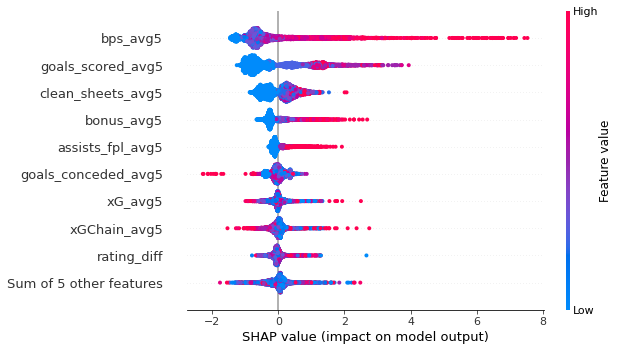

In [15]:
# feature influence
shap.plots.beeswarm(shap_values)